## Evaluation

In [115]:
import json
import torch
import numpy as np
import sys
import os

from tqdm import tqdm

from rdkit import Chem, RDLogger

# Shut up RDKit
logger = RDLogger.logger()
logger.setLevel(RDLogger.CRITICAL)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw


In [2]:
sys.path.append('./SD_LSTM/')
sys.path.append('./LSTM/')

from sd_lstm_sampler import SDLSTMSampler
from sd_lstm_utils import load_model as load_sd_lstm_model

from fast_rnn_sampler import FastSampler
# from rnn_sampler import ConditionalSmilesRnnSampler
from rnn_utils import load_rnn_model

In [3]:
sys.path.append('../utils/')
from property_calculator import PropertyCalculator

pc = PropertyCalculator(['LogP'])

In [4]:
# Clear modules cache
'''
del sys.modules['fast_rnn_sampler']
import importlib
importlib.invalidate_caches()
'''

"\ndel sys.modules['fast_rnn_sampler']\nimport importlib\nimportlib.invalidate_caches()\n"

### Load Models

In [5]:
# Load SD-LSTM Model

# sd_lstm_model_path = "models/SD_LSTM_QM9/batch_size_20_1/"
# sd_lstm_weights_fname = "LSTM_14_1.167.pt"
# sd_lstm_definition_fname = "LSTM_14_1.167.json"

sd_lstm_model_path = "models/SD_LSTM_QM9/batch_size_20_1/"
sd_lstm_weights_fname = "LSTM_20_1.682.pt"
sd_lstm_definition_fname = "LSTM_20_1.682.json"


sd_lstm_sampler = SDLSTMSampler(device = 'cpu', rules_dict_size = 80, batch_size=64)
sd_lstm_model = load_sd_lstm_model(
            model_definition= os.path.join(sd_lstm_model_path, sd_lstm_definition_fname),
            model_weights = os.path.join(sd_lstm_model_path, sd_lstm_weights_fname),
            device = 'cpu',
            )

with open(os.path.join(sd_lstm_model_path, sd_lstm_definition_fname)) as pfile:
    model_params = json.load(pfile)

sd_lstm_mpar = model_params['property_names']
print(f'cLSTM Conditioned on Following Props: {sd_lstm_mpar}')

cLSTM Conditioned on Following Props: ['LogP']


In [6]:
# Load LSTM Model

lstm_model_path = "models/LSTM_QM9/batch_size_20_2"
lstm_weights_fname = "LSTM_8_1.151.pt"
lstm_definition_fname = "LSTM_8_1.151.json"


lstm_sampler = FastSampler(device = 'cpu', batch_size=64)
lstm_model = load_rnn_model(
            model_definition= os.path.join(lstm_model_path, lstm_definition_fname),
            model_weights = os.path.join(lstm_model_path, lstm_weights_fname),
            device = 'cpu',
            )
    
with open(os.path.join(lstm_model_path, lstm_definition_fname)) as pfile:
    model_params = json.load(pfile)

lstm_mpar = model_params['property_names']
print(f'cLSTM Conditioned on Following Props: {lstm_mpar}')

cLSTM Conditioned on Following Props: ['LogP']


In [7]:
sd_lstm_sampler.sample(model=sd_lstm_model, properties=torch.Tensor([[-3.0], [-3.5]]), num_to_sample = 2, max_seq_len=100)

['C(C(O))', 'CC(O)']

# Dataset

In [8]:
dataset_path = "data/QM9/"
qmds = pd.read_csv(os.path.join(dataset_path, 'QM9_clean.csv'))
print(qmds.columns)
props = list(qmds.drop(['QM9_id', 'SMILES'], axis=1).columns)
print(f'Properties in dataset: {props}')

Index(['QM9_id', 'SMILES', 'LogP'], dtype='object')
Properties in dataset: ['LogP']


### Target Property Distributions

In [9]:
prop_names = ['LogP']

In [10]:
# Distribution of property scores computed from dataset SMILES
# TODO: Not currently multiprop
calculated_ds_props = []
for smi in tqdm(qmds['SMILES']):
    mol = Chem.MolFromSmiles(smi)
    calculated_ds_props.append(pc(mol))

calc_props = {}
for i in tqdm(range(len(prop_names))):
    calc_props[prop_names[i]] = [a[i] for a in calculated_ds_props]


  0%|          | 0/133885 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 239.14it/s]


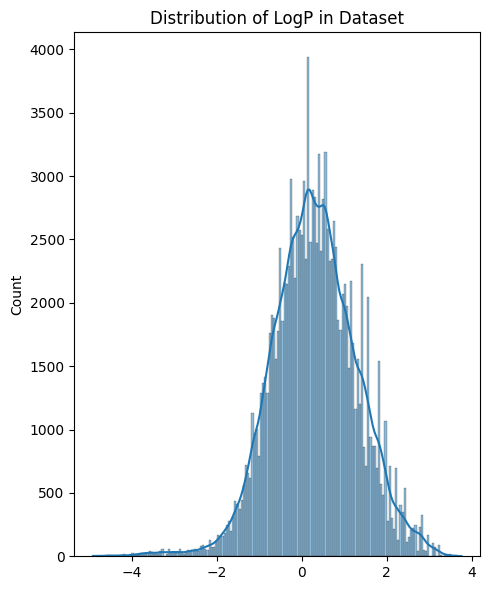

In [11]:
# Distribution of property scores in dataset
plt.figure(figsize=(len(prop_names) * 5, 6))  # Adjust the size as needed

for i, column in enumerate(prop_names):
    plt.subplot(1, len(prop_names), i + 1)  # (1, total number of columns, current column index)
    sns.histplot(calc_props[column], kde=True)  # Using seaborn to plot the distribution with a Kernel Density Estimate
    plt.title(f'Distribution of {column} in Dataset')

plt.tight_layout()
plt.show()

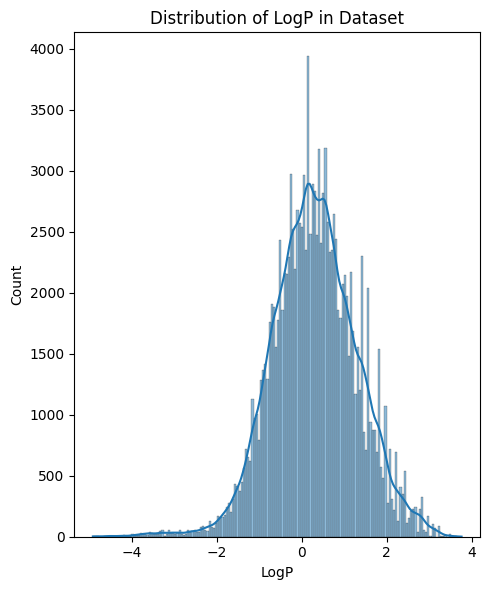

In [12]:
# Distribution of property scores in dataset
plt.figure(figsize=(len(prop_names) * 5, 6))  # Adjust the size as needed

for i, column in enumerate(prop_names):
    plt.subplot(1, len(prop_names), i + 1)  # (1, total number of columns, current column index)
    sns.histplot(qmds[column], kde=True)  # Using seaborn to plot the distribution with a Kernel Density Estimate
    plt.title(f'Distribution of {column} in Dataset')

plt.tight_layout()
plt.show()

# Compute Performance Metrics

In [151]:
def return_valid_smiles(smiles_list):
    '''
    return smiles list with invalid smiles removed
    '''
    valid = []
    for smi in smiles_list:
        try:
            mol = Chem.MolFromSmiles(smi)
            if mol is not None:
                valid.append(smi)
        except:
            pass
    return valid

In [13]:
def compute_validity_pct(smiles_list):
    '''
    Retrun proportion of SMILES that is valid
    '''
    # Silence RDKit
    RDLogger.DisableLog('rdApp.*')  

    cval = 0
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            cval += 1

    if(len(smiles_list) == 0):
        return 0.0
    else:
        return cval / len(smiles_list)

In [14]:
def props_from_smiles(smiles_list, verbose=True):
    '''
    Computes property scores of all valid smiles and returns as list
    '''
    if verbose:
        smiles_list = tqdm(smiles_list)
    props = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            props.append(pc(mol)[0])
    return props

In [15]:
def compute_diversity_metrics(smiles_list):
    '''
    - Ignores invalid smiles
    - Uses morgan fingerprints
    Return:
    [Pct Unique, Tanimoto Diversity, Internal Diversity]
    '''
    valid_smiles = []
    fingerprints = []

    print('Checking validity and computing fingerprints')
    for smi in tqdm(smiles_list):
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            continue
        
        valid_smiles.append(smi)
        fingerprints.append(AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024))

    # Compute pairwise Tanimoto similarities
    n = len(fingerprints)
    similarities = []
    print('Computing pairwise similarities')
    for i in range(n):
        for j in range(i + 1, n): 
            similarity = DataStructs.FingerprintSimilarity(fingerprints[i], fingerprints[j])
            similarities.append(similarity)

    # Calculate pct Unique
    uniquness = len(set(valid_smiles)) / len(valid_smiles)
    # Calculate Tanimoto Diversity as the average similarity
    tanimoto_diversity = np.mean(similarities)
    # Calculate Internal Diversity as the average dissimilarity
    internal_diversity = np.mean([1 - s for s in similarities])
    return [uniquness, tanimoto_diversity, internal_diversity]

In [16]:
def canonicalize_smiles_list(smiles_list):
    '''
    Returns list of canonical smiles
    
    Warning: If smiles are invalid, will skip. Indecies are therefore not preserved
    '''
    cans = []
    print("Converting to canonical smiles:")
    for smi in tqdm(smiles_list):
        try:
            cans.append(Chem.MolToSmiles(Chem.MolFromSmiles(smi), True))
        except:
            continue
    return cans

In [17]:
def compute_absolute_novelty(smiles_list, ds_smiles, canonicalize_dataset =  True):
    '''
    Guacamol considers proportion that is novel unique out unique canonical smiles generated
    Should be fed invalid smiles aswell

    optionally canonicalize dataset smiles
    
    - Similar to Guacamol def
    Only consider proportion of valid smiles
    Only consider propotion of unique smiles
    '''
    
    # Filter out invalid
    smiles_list = canonicalize_smiles_list(smiles_list)

    if canonicalize_dataset:
        print('Canonicalizing dataset smiles:')
        ds_smiles = canonicalize_smiles_list(ds_smiles)

    if len(smiles_list) == 0:
        raise Exception("Novelty: No Valid Smiles Genereated!!!")

    # Get unique canonical smiles
    smiles_list = set(smiles_list)
    novel = []
    for smi in smiles_list:
        if smi not in ds_smiles:
            novel.append(smi)

    return len(novel) / len(smiles_list)

In [18]:
def compute_correlation(computed_property_values, target_property_values):
    '''
    Compute correlation between two 1D arrays of properties
    Two numpy arrays, one of computed property values and one of target property values

    Returns correlation coeff
    '''
    assert len(computed_property_values) == len(target_property_values)

    computed_property_values = np.array(computed_property_values)
    target_property_values = np.array(target_property_values)

    if np.var(computed_property_values) == 0 or np.var(target_property_values) == 0:
        return 'Undefined due to zero variance in one of the arrays'

    corr_matrix = np.corrcoef(computed_property_values, target_property_values)
    corr = corr_matrix[0, 1]
    return corr


In [19]:
def guacamol_KLD():
    '''
    ....
    '''

    raise Exception("Not Implemented")

In [20]:
def guacamol_FCD_score():
    '''
    To generate the FCD score, a random subset of 10’000 molecules is selected from the ChEMBL dataset, and the generative model is sampled 19 
    until 10’000 valid molecules are obtained. The FCD between both sets of molecules is calculated with the FCD package available on GitHub,86 and the final score S is given by

    Score = exp(-0.2 * FCD)
    '''
    raise Exception("Not Implemented")

In [21]:
def guacamol_uniqueness():
    '''
    The validity score is calculated as the ratio of valid molecules out of 10’000
    generated molecules. Molecules are considered to be valid if their SMILES representation
    can be successfully parsed by RDKit.
    '''
    # TODO: Slow to execute
    raise Exception("Not Implemented")

In [22]:
def guacamol_uniqueness():
    ''' 
    To calculate the uniqueness score, molecules are sampled from the generative
    model until 10’000 valid molecules have been obtained. Duplicate molecules are identified
    by identical canonical SMILES strings. The score is obtained as the number of different
    canonical SMILES strings divided by 10’000.
    '''
    # TODO: Slow to execute
    raise Exception("Not Implemented")

In [23]:
def guacamol_novelty():
    '''
    The novelty score is calculated by generating molecules until 10’000 different
    canonical SMILES strings are obtained, and computing the ratio of molecules not present in
    the ChEMBL dataset.
    '''
    # Due to the low diversity I'll wait a bit, since this could take bloody ages to generate
    raise Exception("Not Implemented")

In [99]:
def compute_all_metrics(smiles_list, target_property_values, ds_smiles, corr = True, canonicalize_dataset=False):
    '''
    Ignores invalid smiles for reasons other than validity

    Inputs:
     - smiles_list: list of generated smiles
     - target_property_values: 
     - ds_smiles

    returns: [ (optional) correlation, validity_pct, unique_pct, diversity, novelty]    
    '''
    if len(smiles_list) == 0:
        raise Exception("No valid smiles provided")

    smiles_list = np.array(smiles_list)    
    ds_smiles = np.array(ds_smiles)  

    #if corr:
    #    target_property_values = np.array([float(p[0]) for p in target_property_values])

    # Compute Novelty
    novelty = compute_absolute_novelty(smiles_list, ds_smiles, canonicalize_dataset=canonicalize_dataset)

    # Indexes of valid smiles and validity
    valid_idxs = []
    computed_prop_vals = []

    for ind in range(len(smiles_list)):
        try:
            mol = Chem.MolFromSmiles(smiles_list[ind])
            props = pc(mol)
            valid_idxs.append(ind)
            computed_prop_vals.append(props)
        except:
            continue


    if corr:
        valid_target_props = target_property_values[valid_idxs]

    validity = len(valid_idxs) / len(smiles_list)

    # proportion of valid molecules that are unique
    unique_pct, tanimoto, diversity = compute_diversity_metrics(smiles_list)
    
    # Compute Valid pct
    if corr:
        correlations = []
        for i in range(len(target_property_values[0])):
            comp_prop = np.array([float(c[i]) for c  in computed_prop_vals])
            tar_prop = np.array([float(c[i]) for c in valid_target_props])
            
            correlations.append(compute_correlation(comp_prop, tar_prop))

        return correlations, validity, unique_pct, diversity, novelty

    else:
        return validity, unique_pct, diversity, novelty 
    

In [102]:
# Test
print(compute_all_metrics(['CCO', 'CO'], [[1, -60],[2, 60]], ['CCO', 'NO', 'NNO']))

#correlations, validity, unique_pct, diversity, novelty = compute_all_metrics(lstm_global_sample_smiles, targets, list(qmds['SMILES']))
#print(correlations)

Converting to canonical smiles:


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 11812.78it/s]


Checking validity and computing fingerprints


100%|██████████| 1000/1000 [00:00<00:00, 22638.51it/s]

Computing pairwise similarities


[0.9877771468783321]


## Global Sample Uniform Prop Vals

In [62]:
n_samples = 1000
property_val_range = [-5, 5]

targets = np.random.uniform(low=property_val_range[0], high=property_val_range[1], size=n_samples)
targets = torch.Tensor([[a] for a in targets])

In [106]:
# Sample SD_LSTM
# TODO: About .5 percent still fails to decode somehow
sd_lstm_global_sample_smiles = []
sd_lstm_global_targets = []
print('Sampling SD_LSTM Model with Random Uniform Targets')

sd_lstm_global_sample_smiles = sd_lstm_sampler.sample(model=sd_lstm_model, properties=targets, num_to_sample=1000, max_seq_len=100)

print(len(sd_lstm_global_sample_smiles))
assert(len(sd_lstm_global_sample_smiles) == n_samples)

Sampling SD_LSTM Model with Random Uniform Targets
1000


In [105]:
# Sample LSTM
lstm_global_sample_smiles = []
lstm_global_targets = []
print('Sampling SD_LSTM Model with Random Uniform Targets')

lstm_global_sample_smiles = lstm_sampler.sample(model=lstm_model, properties=targets, num_to_sample=1000, max_seq_len=100)

assert(len(lstm_global_sample_smiles) == n_samples)


Sampling SD_LSTM Model with Random Uniform Targets


In [65]:
## Compute property scores
lstm_global_properties = props_from_smiles(lstm_global_sample_smiles)
sd_lstm_global_properties = props_from_smiles(sd_lstm_global_sample_smiles)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 17568.94it/s]


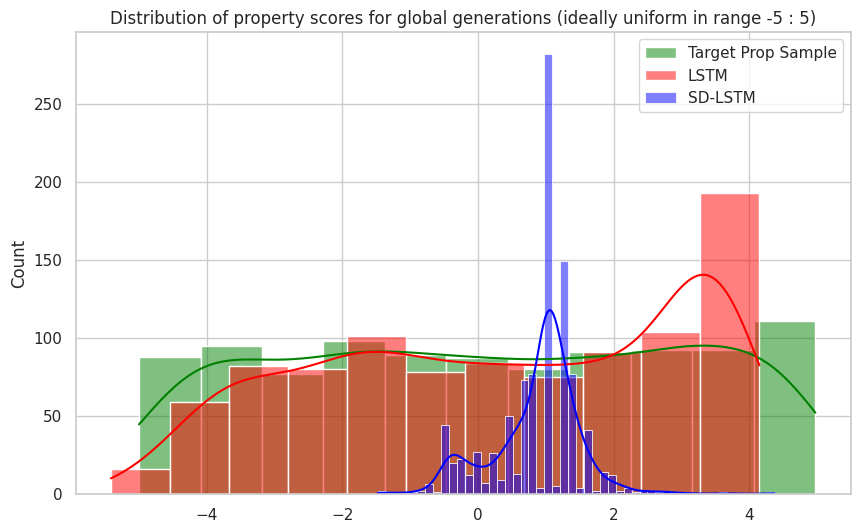

In [75]:
# Distribution of property scores in dataset

# Setting up the seaborn style
# sns.set(style='whitegrid')

# Create a distribution plot using seaborn
plt.figure(figsize=(10, 6))

# Plotting both distributions on the same plot
sns.histplot([ float(a[0]) for a in targets], color="green", label='Target Prop Sample', kde=True)
sns.histplot(lstm_global_properties, color="red", label='LSTM', kde=True)
sns.histplot(sd_lstm_global_properties, color="blue", label='SD-LSTM', kde=True)

pval0 = property_val_range[0]
pval1 = property_val_range[1]

plt.title(f'Distribution of property scores for global generations (ideally uniform in range {pval0} : {pval1})')
# Adding legend to the plot
plt.legend()

# Show the plot
plt.show()

In [109]:
correlations, validity, unique_pct, diversity, novelty = compute_all_metrics(sd_lstm_global_sample_smiles, targets, list(qmds['SMILES']))
print( f'SD-LSTM \n Correlation: {correlations} \n Validity: {validity} \n Unique PCT: {unique_pct} \n Diversity: {diversity} \n Novelty: {novelty} ')

Converting to canonical smiles:


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 32465.16it/s]


Checking validity and computing fingerprints


100%|██████████| 1000/1000 [00:00<00:00, 38165.77it/s]

Computing pairwise similarities


SD-LSTM 
 Correlation: [-0.07348901173538082] 
 Validity: 1.0 
 Unique PCT: 0.208 
 Diversity: 0.7682856294169682 
 Novelty: 0.8345323741007195 


In [110]:
correlations, validity, unique_pct, diversity, novelty = compute_all_metrics(lstm_global_sample_smiles, np.array([[i] for i in targets]), list(qmds['SMILES']))
print( f'LSTM \n Correlation: {correlations} \n Validity: {validity} \n Unique PCT: {unique_pct} \n Diversity: {diversity} \n Novelty: {novelty} ')

Converting to canonical smiles:


100%|██████████| 1000/1000 [00:00<00:00, 16352.95it/s]


Checking validity and computing fingerprints


100%|██████████| 1000/1000 [00:00<00:00, 18629.35it/s]

Computing pairwise similarities


LSTM 
 Correlation: [0.9886706428310941] 
 Validity: 0.946 
 Unique PCT: 0.8604651162790697 
 Diversity: 0.9194439827914456 
 Novelty: 0.23388116308470291 


/tmp/ipykernel_56739/2082384926.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tar_prop = np.array([float(c[i]) for c in valid_target_props])


**SD LSTM 20 Epoch**
- Correlation: [-0.07348901173538082] 
- Validity: 1.0 
- Unique PCT: 0.208 
- Diversity: 0.7682856294169682 
- Novelty: 0.8345323741007195 

 **LSTM 20 Epoch**

- Correlation: [0.9886706428310941] 
- Validity: 0.946 
- Unique PCT: 0.8604651162790697 
- Diversity: 0.9194439827914456 
- Novelty: 0.23388116308470291 

### Visualise sample of smiles

In [123]:
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt

def plot_smiles(smiles_list, title="SMILES Plot"):
    """
    Plots a 10x10 grid of molecular structures from a list of SMILES strings,
    with no space between plots and no axes.

    Args:
    smiles_list (list): List of SMILES strings.
    title (str): Title of the plot.
    """
    # remove invalid smiles and make sure we have enough
    smiles_list = return_valid_smiles(sd_lstm_global_sample_smiles)
    assert len(smiles_list) > 100

    # pick 100 at random
    smiles_list = np.random.choice(smiles_list, size=100, replace=False)
    
    # Convert SMILES to RDKit molecule objects
    molecules = [Chem.MolFromSmiles(smile) for smile in smiles_list]

    # Create a 10x10 subplot with no spaces between subplots
    fig, axs = plt.subplots(10, 10, figsize=(10, 10))
    fig.suptitle(title, fontsize=20)
    plt.subplots_adjust(wspace=0, hspace=0)  # Remove spaces between plots

    for i, ax in enumerate(axs.flat):
        ax.axis("off")  # Turn off the axes

        if i < len(molecules):
            mol = molecules[i]
            if mol is not None:
                # Convert RDKit molecule to an image and display it
                img = Draw.MolToImage(mol, size=(150, 150))
                ax.imshow(img)

    plt.show()

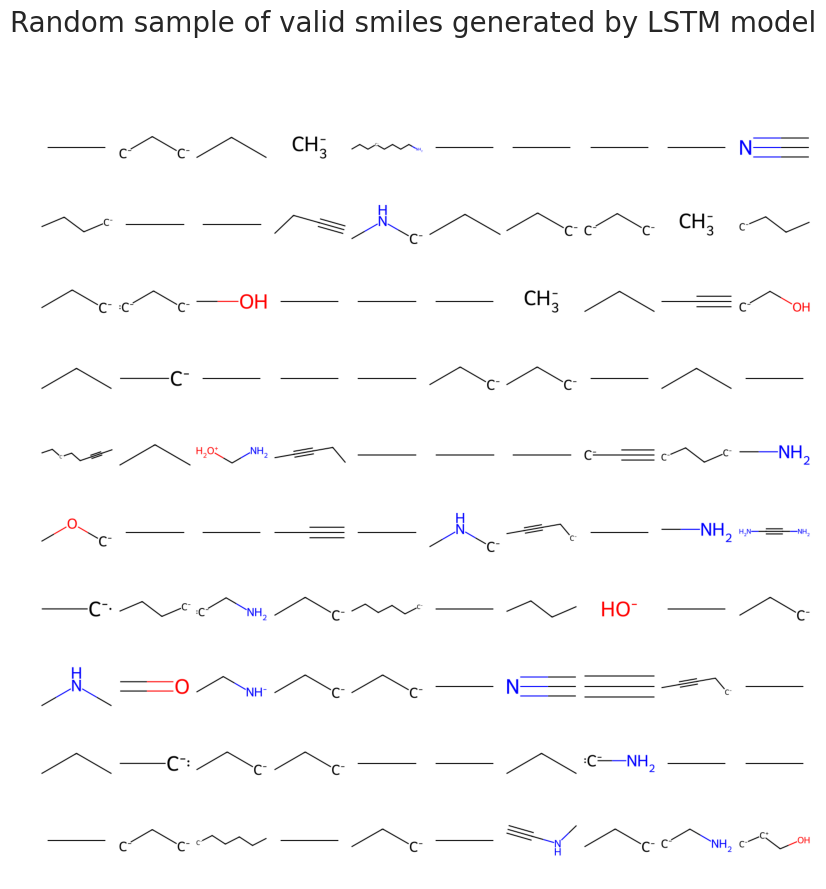

In [124]:
plot_smiles(lstm_global_sample_smiles, title="Random sample of valid smiles generated by LSTM model")


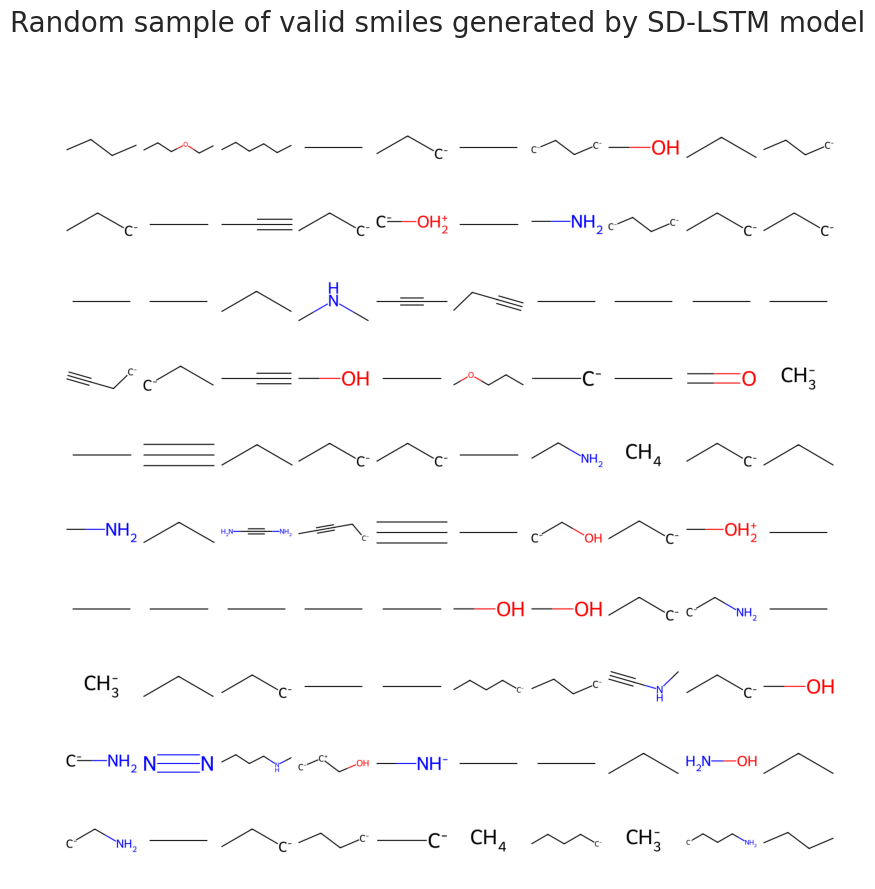

In [125]:
plot_smiles(sd_lstm_global_sample_smiles, title="Random sample of valid smiles generated by SD-LSTM model")


# Performance as a Funct. of Target Value

In [148]:
property_steps = np.arange(-3, 3, 0.1)
samp_per_step = 500

In [149]:
# Sample LSTM at prop steps
lstm_pstep_smiles = {
    'validity': [],
    'unique_pct': [],
    'diversity': [],
    'novelty':[]
    }


for p_val in tqdm(property_steps):
    props = torch.Tensor([[p_val] for i in range(samp_per_step)])
    smiles = []
    smiles = lstm_sampler.sample(model=lstm_model, properties=torch.Tensor(props), num_to_sample = samp_per_step, max_seq_len=100)
    smiles += ['ERROR' * missing]

    validity, unique_pct, diversity, novelty = compute_all_metrics(smiles, props, list(qmds['SMILES']), corr=False)
    lstm_pstep_smiles['validity'].append(validity)
    lstm_pstep_smiles['unique_pct'].append(unique_pct)
    lstm_pstep_smiles['diversity'].append(diversity)
    lstm_pstep_smiles['novelty'].append(novelty)


# Now for sd_lstm
sd_lstm_pstep_smiles = {
    'validity': [],
    'unique_pct': [],
    'diversity': [],
    'novelty':[]
    }


for p_val in tqdm(property_steps):
    props = torch.Tensor([[p_val] for i in range(samp_per_step)])
    smiles = []
    # Unlike the uniform sample this one tends to fail a few times, so we add fake smiles back in to get the correct numbers for novely ETC

    smiles = sd_lstm_sampler.sample(model=sd_lstm_model, properties=torch.Tensor(props), num_to_sample = samp_per_step, max_seq_len=100)

    missing = n_samples - len(smiles)

    smiles += ['ERROR' * missing]
    validity, unique_pct, diversity, novelty = compute_all_metrics(smiles, props, list(qmds['SMILES']), corr=False)

    sd_lstm_pstep_smiles['validity'].append(validity)
    sd_lstm_pstep_smiles['unique_pct'].append(unique_pct)
    sd_lstm_pstep_smiles['diversity'].append(diversity)
    sd_lstm_pstep_smiles['novelty'].append(novelty)


Converting to canonical smiles:


100%|██████████| 458/458 [00:00<00:00, 10958.99it/s]


Checking validity and computing fingerprints


100%|██████████| 458/458 [00:00<00:00, 9822.63it/s]

Computing pairwise similarities



100%|██████████| 60/60 [18:01<00:00, 18.03s/it]


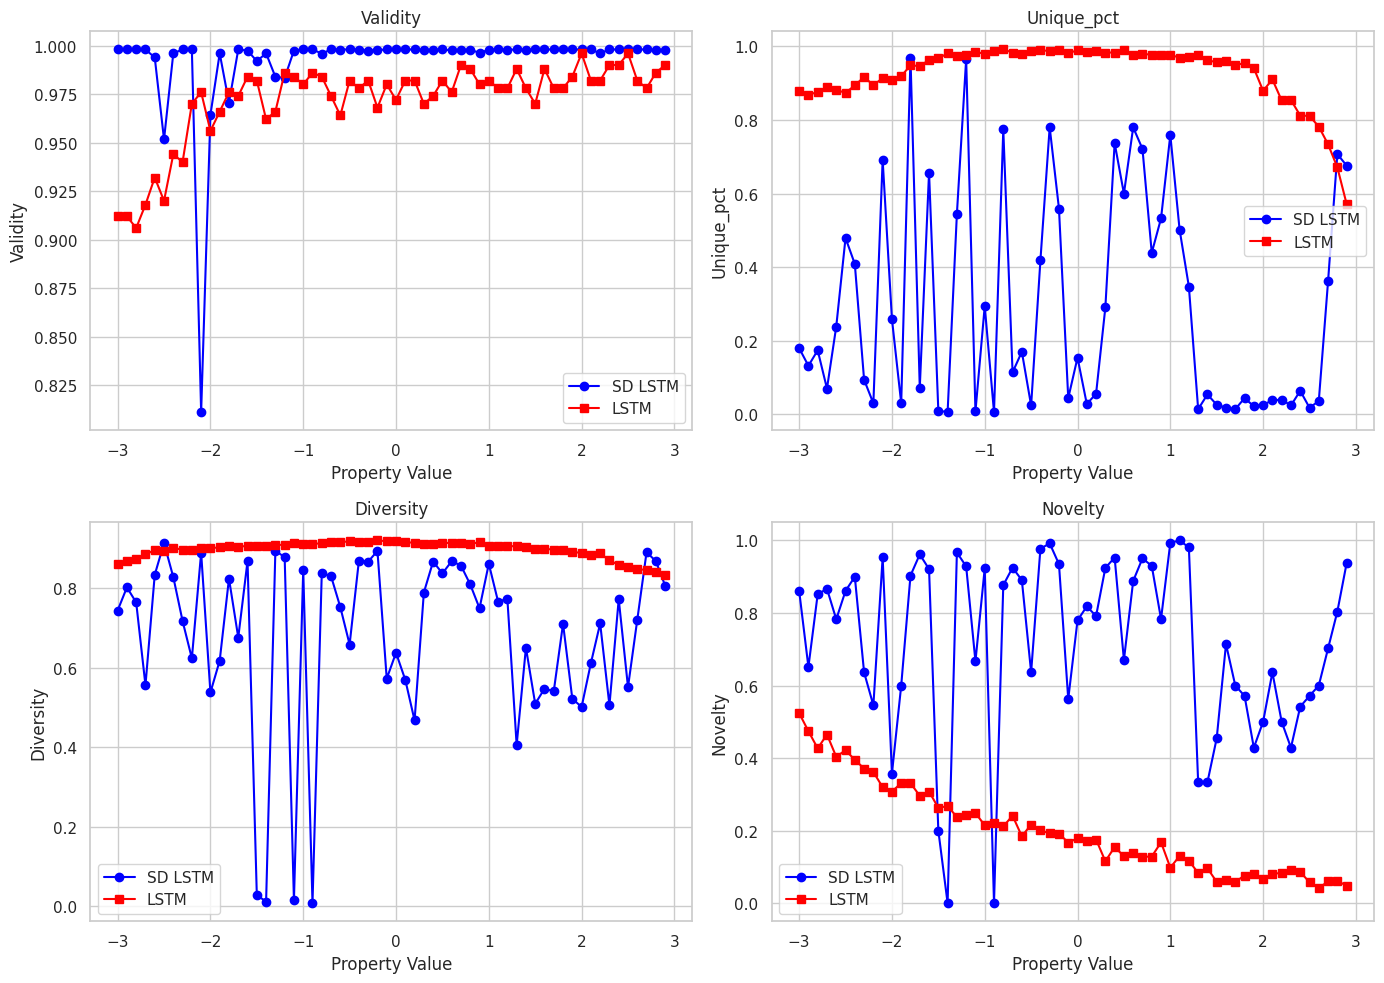

In [150]:
# Assume we have properties for both models in sd_lstm_pstep_smiles and lstm_pstep_smiles
keys = ['validity', 'unique_pct', 'diversity', 'novelty']

plt.figure(figsize=(14, 10))

for i, key in enumerate(keys, 1):
    plt.subplot(2, 2, i)
    plt.plot(property_steps, sd_lstm_pstep_smiles[key], label='SD LSTM', marker='o', linestyle='-', color = 'blue')
    plt.plot(property_steps, lstm_pstep_smiles[key], label='LSTM', marker='s', linestyle='-', color='red')
    
    plt.title(key.capitalize())
    plt.xlabel('Property Value')
    plt.ylabel(key.capitalize())
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [160]:
# Plot conditional generation performance

property_steps = np.arange(-2, 2.5, 0.5)
samp_per_step = 100

lstm_steps_properties = []
lstm_steps_stats =  {
    'Failed to decode':[],
    'Invalid Smiles':[],
    'Valid': []
}

sd_lstm_steps_properties = []
sd_lstm_steps_stats = {
    'Failed to decode':[],
    'Invalid Smiles':[],
    'Valid': []
}

for p_val in tqdm(property_steps):
    # SD-LSTM
    props = torch.Tensor([[p_val] for i in range(samp_per_step)])
    smiles = sd_lstm_sampler.sample(model=sd_lstm_model, properties=torch.Tensor(props), num_to_sample = samp_per_step, max_seq_len=100)
    missing = samp_per_step - len(smiles)
    valid_smiles = return_valid_smiles(smiles)
    invalid = (samp_per_step - missing) - len(valid_smiles)
    properties = props_from_smiles(valid_smiles)

    sd_lstm_steps_properties.append(properties)
    sd_lstm_steps_stats['Failed to decode'].append(missing)
    sd_lstm_steps_stats['Invalid Smiles'].append(invalid)
    sd_lstm_steps_stats['Valid'].append(samp_per_step - missing - invalid)


    props = torch.Tensor([[p_val] for i in range(samp_per_step)])
    smiles = lstm_sampler.sample(model=lstm_model, properties=torch.Tensor(props), num_to_sample = samp_per_step, max_seq_len=100)
    missing = samp_per_step - len(smiles)
    valid_smiles = return_valid_smiles(smiles)
    invalid = (samp_per_step - missing) - len(valid_smiles)
    properties = props_from_smiles(valid_smiles)

    lstm_steps_properties.append(properties)
    lstm_steps_stats['Failed to decode'].append(missing)
    lstm_steps_stats['Invalid Smiles'].append(invalid)
    lstm_steps_stats['Valid'].append(samp_per_step - missing - invalid)


100%|██████████| 9/9 [01:08<00:00,  7.57s/it]


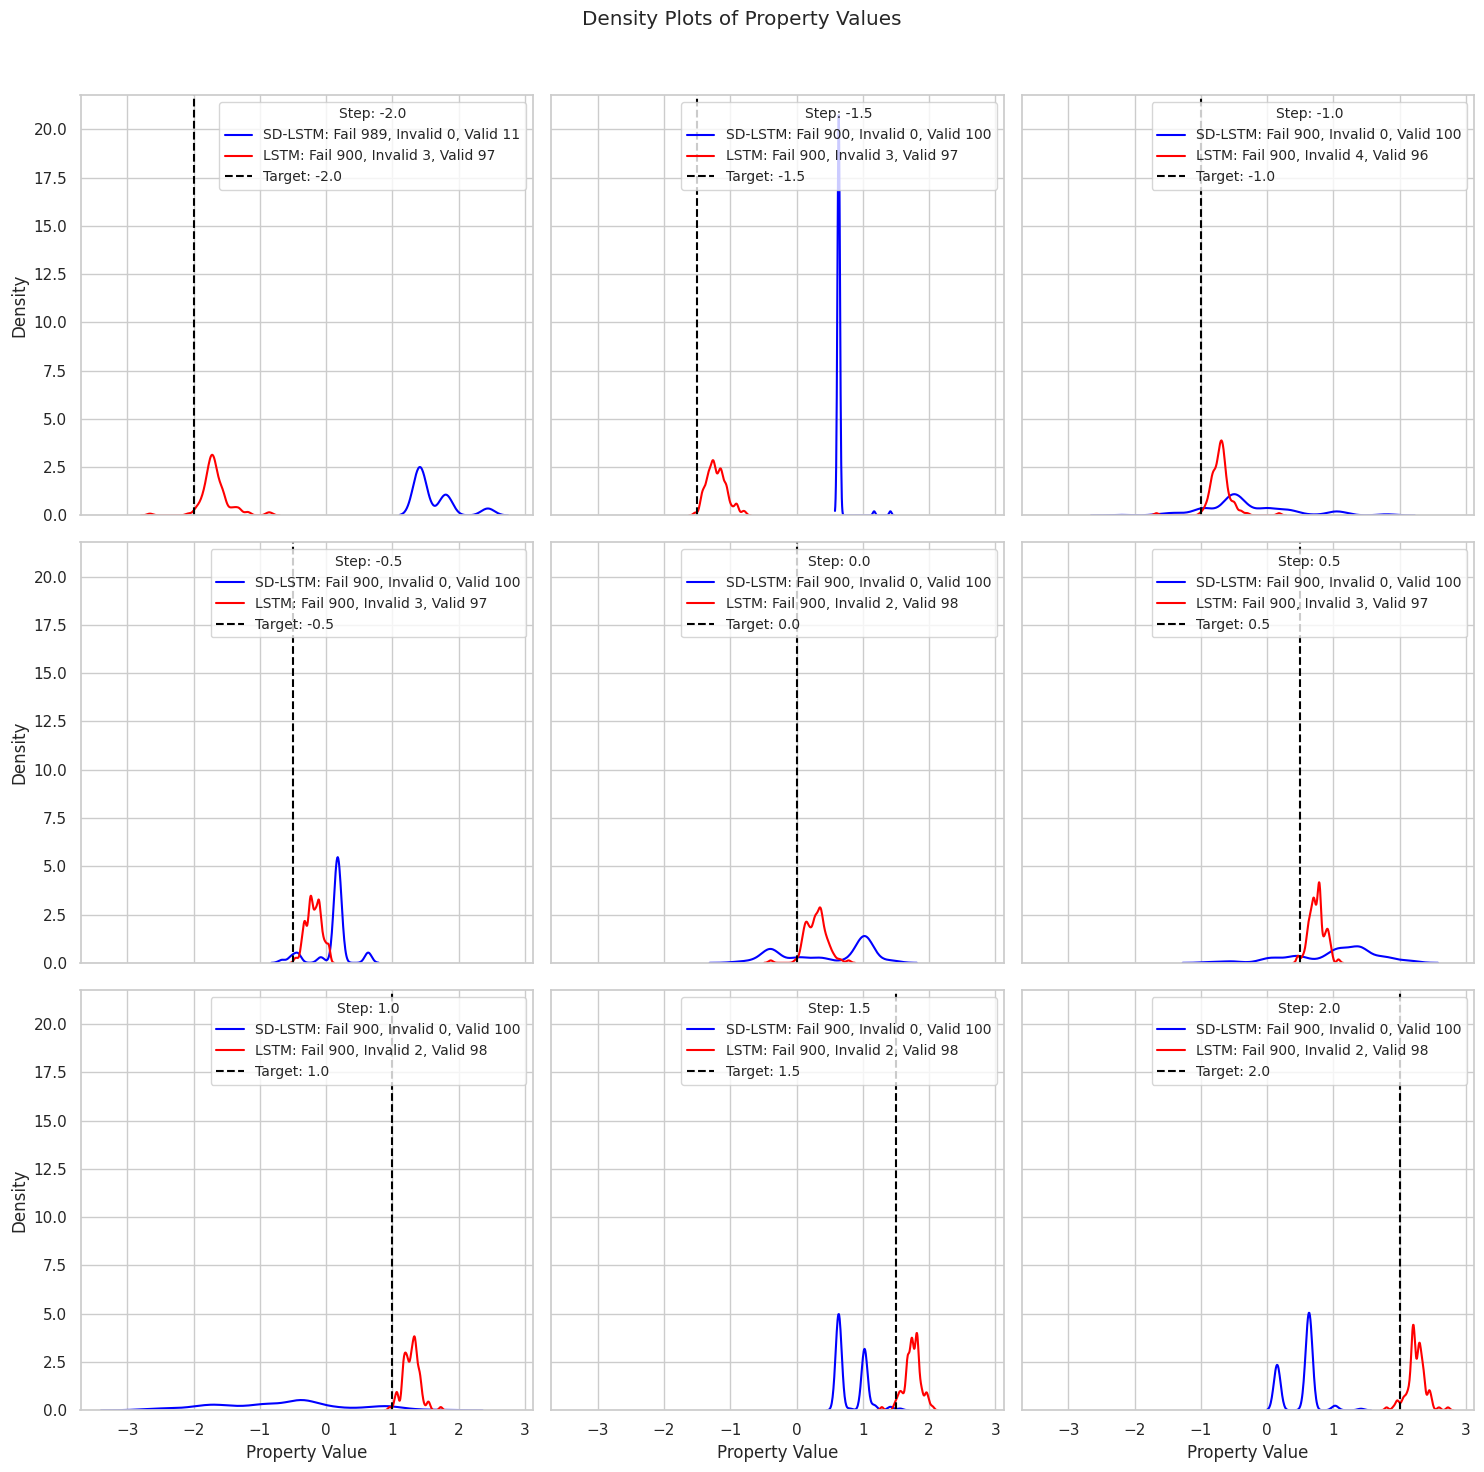

In [161]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
fig.suptitle('Density Plots of Property Values')

# Flatten the axes for easy iteration
axes_flat = axes.flatten()

# Loop through each property step and create the corresponding plot
for i, p_val in enumerate(property_steps):
    ax = axes_flat[i]
    
    # Plot density for SD-LSTM
    if sd_lstm_steps_properties[i]:  # Check if not empty
        sns.kdeplot(sd_lstm_steps_properties[i], ax=ax, color='blue', label='SD-LSTM', bw_adjust=0.5)
    
    # Plot density for LSTM
    if lstm_steps_properties[i]:  # Check if not empty
        sns.kdeplot(lstm_steps_properties[i], ax=ax, color='red', label='LSTM', bw_adjust=0.5)
    
    # Vertical line for the target property value
    ax.axvline(x=p_val, color='black', linestyle='--', label=f'Target: {p_val}')
    
    # Adding legend
    ax.legend(title=f'Step: {p_val}', loc='upper right', fontsize='small', title_fontsize='small', 
              labels=[
                  f'SD-LSTM: Fail {sd_lstm_steps_stats["Failed to decode"][i]}, Invalid {sd_lstm_steps_stats["Invalid Smiles"][i]}, Valid {sd_lstm_steps_stats["Valid"][i]}',
                  f'LSTM: Fail {lstm_steps_stats["Failed to decode"][i]}, Invalid {lstm_steps_stats["Invalid Smiles"][i]}, Valid {lstm_steps_stats["Valid"][i]}',
                  f'Target: {p_val}'
              ])

    # Setting labels for each subplot
    ax.set_xlabel('Property Value')
    ax.set_ylabel('Density')

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle

# Show the plot
plt.show()